In [56]:
import os
import cv2
import glob
import json
import hashlib
import numpy as np
import pandas as pd
import time
# import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Load dataset

In [2]:
train_df = pd.read_csv('dataset/train.csv')
train_df.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


## Preprocess data

In [3]:
bboxes = np.array(train_df.apply(lambda x: json.loads(x['bbox']), axis=1).tolist())

In [4]:
train_df['x_min'] = bboxes[:, 0]
train_df['y_min'] = bboxes[:, 1]
train_df['x_max'] = bboxes[:, 0] + bboxes[:, 2]
train_df['y_max'] = bboxes[:, 1] + bboxes[:, 3]

In [5]:
train_df = train_df.drop(['width', 'height', 'bbox'], axis=1)

In [6]:
print('Columns: ', train_df.columns.values)

Columns:  ['image_id' 'source' 'x_min' 'y_min' 'x_max' 'y_max']


In [7]:
train_df.head(5)

,image_id,source,x_min,y_min,x_max,y_max
0,b6ab77fd7,usask_1,834.0,222.0,890.0,258.0
1,b6ab77fd7,usask_1,226.0,548.0,356.0,606.0
2,b6ab77fd7,usask_1,377.0,504.0,451.0,664.0
3,b6ab77fd7,usask_1,834.0,95.0,943.0,202.0
4,b6ab77fd7,usask_1,26.0,144.0,150.0,261.0


## Check sanity of dataset

In [48]:
def list_files_ignore_dsstore(path):
    return [file for file in os.listdir(path) if file != '.DS_Store']


# Check extension
def check_image_extension(path):
    extensions = {}
    file_list = list_files_ignore_dsstore(path)
    
    for file in file_list:
        extension = file.rsplit('.')[1]
        
        if extension in extensions:
            extensions[extension] += 1
        else:
            extensions[extension] = 1
    
    return extensions


# Check image size
def check_image_size(path, width, height):
    file_list = list_files_ignore_dsstore(path)
    invalid_files = {
        'invalid_total': 0,
        'invalid_files': []
    }
    
    for file in tqdm(file_list, desc='Checking in progress'):
        image_path = '{}/{}'.format(path, file)
        image = cv2.imread(image_path)
        image_height, image_width, _ = image.shape
        
        if not (width == image_width and height == image_height):
            invalid_files['invalid_total'] += 1
            invalid_fields['invalid_files'].append(image_path)
            
    if invalid_files['invalid_total'] > 0:
        print('Check image size: {} invalid images'.format(invalid_files['invalid_total']))
    else:
        print('Check image size: All images are valid')
        
    return invalid_files


# check sanity
def check_sanity(path, csv_path, column):
    file_list = list_files_ignore_dsstore(path)
    invalid_files = {
        'invalid_total': 0,
        'invalid_files': []
    }
    
    df = pd.read_csv(csv_path)
    image_ids = df[column]
    index = 0
    
    for image_id in tqdm(file_list, desc='Checking in progress'):
        image_path = '{}/{}.jpg'.format(path, image_id)
        
        if image_id not in file_list:
            invalid_files['invalid_total'] += 1
            invalid_files['invalid_files'].append(image_path)
        else:
            if not 0 <= train_df.iloc[index]['x_min'] <= 1024 or not 0 <= train_df.iloc[index]['x_max'] <= 1024 or not 0 <= train_df.iloc[index]['y_min'] <= 1024 or not 0 <= train_df.iloc[index]['y_max'] <= 1024:
                # do the same
                invalid_files['invalid_total'] += 1
                invalid_files['invalid_files'].append(image_path)
                
        index += 1
            
    if invalid_files['invalid_total'] > 0:
        print('Check image sanity: {} invalid images'.format(invalid_files['invalid_total']))
    else:
        print('Check image sanity: All images are valid')
        
    return invalid_files

In [17]:
check_image_extension('dataset/train')
check_image_size('dataset/train', 1024, 1024);

print('\n')

check_sanity('dataset/train', 'dataset/train.csv', 'image_id');


Check image size: All images are valid



Check image sanity: All images are valid


## Plot charts

- **ARVALIS - Plant Institute. Institut du Végétal**: ARVALIS - Institut du vegetal is an applied agricultural research organization dedicated to arable crops : cereals, maize, sorghum, potatoes, fodder crops, flax and tobacco. … It considers technological innovation as a major tool to enable producers and agri-companies to respond to societal challenges.

- **ETHZ- ETH Zurich** trains true experts and prepares its students to carry out their tasks as critical members of their communities, making an important contribution to the sustainable development of science, the economy and society.

- **INRAE is France's new National Research Institute for Agriculture, Food and Environment**, created on January 1, 2020, It was formed by the merger of INRA, the National Institute for Agricultural Research, and IRSTEA, the National Research Institute of Science and Technology for the Environment and Agriculture.

- **RRES 90003 is a global engineering specification for Identification Marking Methods and Controls**. It is a Rolls-Royce global document that was compiled for new component designs and will be called out in place of the previous system of JES and EDI specifications.

- **University of Saskatchewan (USask)** researchers played a key role in an international consortium that has sequenced the entire genome of durum wheat—the source of semolina for pasta, a food staple for the world's population, according to an article published today in Nature Genetics

In [19]:
def plot_piechart(df, column, ax=plt):
    value_counts = df[column].value_counts()
    labels = value_counts.index
    values = value_counts.values
    
    ax.pie(values, labels=labels, autopct='%1.2f%%')
    return


# define plot other types here

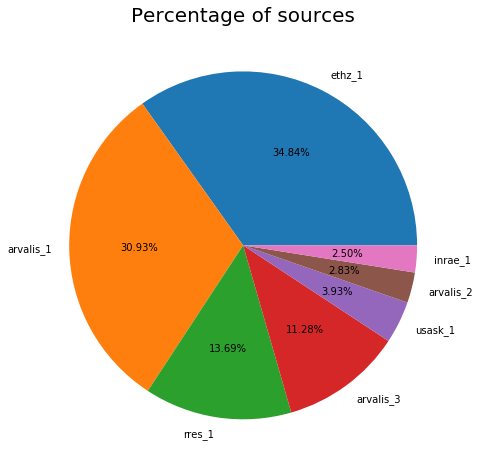

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('Percentage of sources', fontsize=20)
plot_piechart(train_df, 'source', ax)
plt.show()

With **ethz_1** and **arvalis_1** constitute over 75% of the data, the model is likely to overfit to these places' environments.

- **Obstacles**: 
  + Overlap of dense wheat plants, 
  + The wind can blur the photographs
  + Appearances vary due to maturity, color, genotype, and head orientation
  + Because wheat is grown worldwide, different varieties, planting densities, patterns, and field conditions must be considered

- **Requirements**: In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads.

- **Training source**: To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada).

- **Test source**: The test data includes about 1,000 images from Australia, Japan, and China.

--> Models developed for wheat phenotyping need to generalize between different growing environments

## Find duplicate among images:

In [65]:
def hash_image(image_path):
    hash_md5 = hashlib.md5()
    with open(image_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
            
    return hash_md5.hexdigest()


def find_duplicate(path):
    file_list = list_files_ignore_dsstore(path)
    hashes = []
    
    for file in tqdm(file_list, desc='Checking in progress'):
        image_path = '{}/{}'.format(path, file)
        hashes.append(hash_image(image_path))
    
    origin = []
    duplicates = []
    
    for (index, hash_) in enumerate(hashes):
        if hash_ not in origin:
            origin.append(hash_)
        else:
            duplicates.append(index)
    
    return [file_list[i] for i in duplicates]


def measure_execution(script):
    start = time.time()
    eval(script)
    
    return time.time() - start

In [66]:
find_duplicate('dataset/train')

['00333207f copy.jpg']